## Homework 3
#### Problem 1a

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('datasets/churn.txt')


In [2]:
df_clean = pd.DataFrame(df)                             #create a copy of dataframe
df_clean.drop('State', axis = 1, inplace = True)        #drop the objects type for outlier detection of int and float
df_clean.drop('Phone', axis = 1, inplace = True)
df_clean.drop("Int'l Plan", axis = 1, inplace = True)   
df_clean.drop("VMail Plan", axis = 1, inplace = True)
df_clean.drop("Churn?", axis = 1, inplace = True)

from sklearn.neighbors import LocalOutlierFactor        #detect the outliers and remove them
outlier = LocalOutlierFactor(n_jobs = -1)
pred_lof = outlier.fit_predict(df_clean)
pd.crosstab(pred_lof, columns = ['count'])

col_0,count
row_0,
-1,19
1,3314


In [3]:
from sklearn.covariance import EllipticEnvelope
norm2 = EllipticEnvelope()
pred_ee = norm2.fit_predict(df_clean)
pd.crosstab(pred_ee, columns = ['count'])

col_0,count
row_0,
-1,334
1,2999


In [4]:
from sklearn.svm import OneClassSVM
outlier_svm = OneClassSVM(gamma = 'scale', nu = 0.1)
pred_svm = outlier_svm.fit_predict(df_clean)
pd.crosstab(pred_svm, columns = ['count'])

col_0,count
row_0,
-1,331
1,3002


In [5]:
svm_ee = np.intersect1d(np.where(pred_svm == -1), np.where(pred_ee == -1))        #find the intersection between svm and ee
lof_svm_ee = np.intersect1d(np.where(pred_lof == -1), svm_ee)                     #find the intersection between lof and svm+ee
lof_svm_ee


array([ 197,  817, 1397, 2663, 2736, 3075], dtype=int64)

In [6]:
outlier_array = np.intersect1d(np.where(pred_lof == -1), np.where(pred_ee == -1))  #Find the index where pred_lof and pred_ee outliers intersect
df.drop(outlier_array, inplace = True)                                             #drop the outliers that intersect
outlier_array
#df.drop(lof_svm_ee, inplace = True) 


array([ 197,  817, 1397, 2663, 2736, 3075], dtype=int64)

In [7]:
df.drop('Phone', axis = 1, inplace = True)

#indexNames = df[df['Churn?'] == 0 ].index
#n_true = df['Churn?'].value_counts()[1]
#df = df.drop(indexNames[n_true:], inplace = True)

df['Area Code'] = df['Area Code'].astype(object)    #convert Area Code from int to object
#df['Churn?'] = (df['Churn?'] == True).astype(int)   #convert the Churn? (target) from object(True, False) to int (boolean)
object_col = df.select_dtypes(['object']).columns   #select all object types 
df[object_col]
encoding = pd.get_dummies(df, columns = object_col)  #encode all object types into one hot encoding
#encoding.shape
#encoding


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(encoding, train_size = 0.7, shuffle = False)            #split training and testing set with 70:30 ratio
#train


In [9]:
#Now apply minmax normalization on training dataset

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

scaled_values = minmax.fit_transform(train.drop(['Churn?_False.', 'Churn?_True.'] , axis = 1))   #encoded and normalized
                                                                                                 #this is the x_train
#scaled_values.shape

#### Problem 1b

#### (b-1) Using the LocalOutlierFactor, EllipticEnvelope, and OneClassSVM, it can be seen that there are outliers in the dataset. 
#### (b-2) The methods agree on some of the outliers in the dataset which can be shown by using np.intersect1d where an array of intersection of the outliers using different methods are obtained. However, some of outliers do not match due to different assumptions made on the dataset. 
#### (b-3) The OneClassSVM is sensitive to outliers and generally does not perform really well if there are outlier detections. It also expected an input to the outlier percentage to identify outliers. The EllipticEnvelope assumes the dataset is Gaussian distributed and learns an ellipse to perform outlier detection. Therefore, it fits an ellipse to the central data points, and ignores all data points outside the ellipse. The LocalOutlierFactor measures the local density deviation of a data point with respect to its neighbors. The purpose of determing the local density is to detect the samples that have lower density to its neighbor and classify them as outliers. *Note the outliers are removed in part 1a. 

#### Citation: https://scikit-learn.org/stable/modules/outlier_detection.html 

#### Problem 1c

<AxesSubplot:>

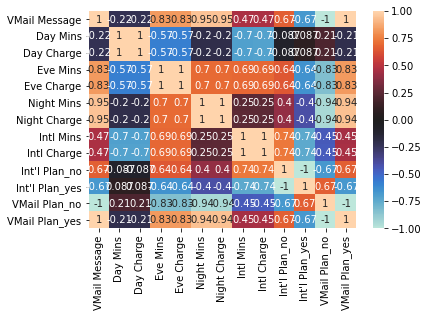

In [10]:
df_new = pd.DataFrame(df)                   
df_new.drop('State', axis = 1, inplace = True)             #remove multicollinear & useless features
df_new.drop('Account Length', axis = 1, inplace = True)
df_new.drop('Area Code', axis = 1, inplace = True)
df_new.drop('Day Calls', axis = 1, inplace = True)
df_new.drop('Eve Calls', axis = 1, inplace = True)
df_new.drop('Night Calls', axis = 1, inplace = True)
df_new.drop('CustServ Calls', axis = 1, inplace = True)
df_new.drop('Intl Calls', axis = 1, inplace = True)
df_new.drop('Churn?', axis = 1, inplace = True)

object_col2 = df_new.select_dtypes(['object']).columns     #select all object types 
df_new[object_col2]
b = pd.get_dummies(df_new, columns = object_col2).head()   #encode all object types into one hot encoding


import seaborn as sns
sns.heatmap(b.corr(), annot = True, vmin = -1, vmax = 1, center = 0)

#### It can be seen from the heatmap above that day mins and day charge are strongly correlated (1.0) to each other. The same can be said for eve mins and eve charge, night mins and night charge, intl mins and intl charge, VMail message and VMail Plan_yes. In addition, there is a strong correlation (0.7) between eve mins and night mins. There is a close to 0 correlation between day mins, day charge and intl charge, intl plan, vmail, plan. This is because a user using a international plan or VMail plan has no correlation to the user using the service during day. There is a negative correlation between the user who uses international plan and user who doesn't use international plan. 

#### Problem 2a

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
#create a 4-layer ANN

model = keras.Sequential()
model.add(layers.Dense(4, input_dim = scaled_values.shape[1], activation = 'sigmoid'))     #number of nodes = 4
model.add(layers.Dense(4, activation = 'sigmoid'))
model.add(layers.Dense(1, activation = 'sigmoid'))                    #output only has 1 node since it is binary classfication



In [13]:
weights = []

class FitCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs = None):
        weights.append(self.model.layers[1].get_weights())
        
        

In [14]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy',
             keras.metrics.Precision(name = "precision", thresholds = 0.5), 
             keras.metrics.Recall(name = 'recall', thresholds = 0.5)])

result = model.fit(scaled_values, train['Churn?_True.'], epochs = 150, batch_size = 50, verbose = 1, 
                   validation_data = (test.drop(['Churn?_False.', 'Churn?_True.'] , axis = 1), test['Churn?_True.']),
                   callbacks = [FitCallback()])
#train['Churn?_True.'] is the y_train

Epoch 1/150
47/47 [==============================] - 0s 10ms/step - loss: 0.1884 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1774 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
47/47 [==============================] - 0s 1ms/step - loss: 0.1646 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1620 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
47/47 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1527 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
47/47 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1472 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
47/47 [========================

47/47 [==============================] - 0s 1ms/step - loss: 0.1132 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/150
47/47 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/150
47/47 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/150
47/47 [==============================] - 0s 2ms/step - loss: 0.1120 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/150
47/47 [==============================] -

47/47 [==============================] - 0s 1ms/step - loss: 0.0996 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2041 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/150
47/47 [==============================] - 0s 1ms/step - loss: 0.0993 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2076 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/150
47/47 [==============================] - 0s 1ms/step - loss: 0.0990 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2104 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 72/150
47/47 [==============================] - 0s 1ms/step - loss: 0.0987 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2133 - val_accuracy: 0.8308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 73/150
47/47 [==============================] -

47/47 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.8677 - precision: 0.5281 - recall: 0.1502 - val_loss: 0.2937 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 105/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0934 - accuracy: 0.8690 - precision: 0.5488 - recall: 0.1438 - val_loss: 0.2943 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 106/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0934 - accuracy: 0.8673 - precision: 0.5213 - recall: 0.1565 - val_loss: 0.2954 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 107/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0932 - accuracy: 0.8681 - precision: 0.5333 - recall: 0.1534 - val_loss: 0.2980 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 108/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0932 - accuracy: 0.8686 - precision: 

47/47 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.8707 - precision: 0.5476 - recall: 0.2204 - val_loss: 0.3434 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 141/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.8703 - precision: 0.5455 - recall: 0.2109 - val_loss: 0.3451 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 142/150
47/47 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.8694 - precision: 0.5338 - recall: 0.2268 - val_loss: 0.3461 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 143/150
47/47 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.8707 - precision: 0.5500 - recall: 0.2109 - val_loss: 0.3467 - val_accuracy: 0.1692 - val_precision: 0.1692 - val_recall: 1.0000
Epoch 144/150
47/47 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.8711 - precision: 

#### The training precision and recall are 0.53 and 0.20 respectively. The test precision and recall are 0.17 and 1.0.

#### Problem 2b

<AxesSubplot:>

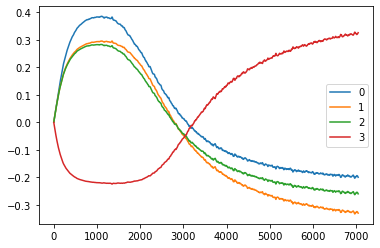

In [15]:
pd.DataFrame([x[-1] for x in weights]).plot()

In [16]:
model.evaluate(scaled_values, train['Churn?_True.'])

73/73 [==============================] - 0s 897us/step - loss: 0.0906 - accuracy: 0.8720 - precision: 0.5581 - recall: 0.2300


[0.09062004834413528,
 0.8719931244850159,
 0.5581395626068115,
 0.23003195226192474]

In [17]:
model.evaluate(test.drop(['Churn?_False.', 'Churn?_True.'] , axis = 1), test['Churn?_True.'])

32/32 [==============================] - 0s 743us/step - loss: 0.3548 - accuracy: 0.1692 - precision: 0.1692 - recall: 1.0000


[0.3547743856906891, 0.16916917264461517, 0.16916917264461517, 1.0]

In [18]:
import matplotlib.pyplot as plt

train_error = []
test_error = []
for i in range(len(result.history['accuracy'])):
    train_error.append(1-result.history['accuracy'][i]) 
    test_error.append(1-result.history['val_accuracy'][i]) 

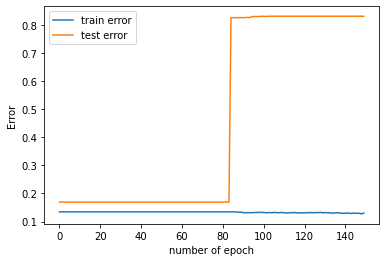

In [19]:
plt.plot(train_error)
plt.plot(test_error)
plt.xlabel('number of epoch')
plt.ylabel('Error')
plt.legend(['train error', 'test error'])

#### Problem 3

In [20]:
train = encoding                             #training set is set to the whole dataset
scaled_values = minmax.fit_transform(train.drop(['Churn?_False.', 'Churn?_True.'] , axis = 1))


In [21]:
model = keras.Sequential()
model.add(layers.Dense(4, input_dim = scaled_values.shape[1], activation = 'sigmoid' ))     #number of nodes = 4
model.add(layers.Dense(4, activation = 'sigmoid' ))
model.add(layers.Dense(1, activation = 'sigmoid' ))                    #output only has 1 node since it is binary classfication


In [22]:
weights = []      #reset the weights to empty list

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy',
             keras.metrics.Precision(name = "precision", thresholds = 0.5), 
             keras.metrics.Recall(name = 'recall', thresholds = 0.5)])

result = model.fit(scaled_values, train['Churn?_True.'], epochs = 150, batch_size = 50, verbose = 1, 
                   callbacks = [FitCallback()])

Epoch 1/150
67/67 [==============================] - 0s 1ms/step - loss: 0.3109 - accuracy: 0.1449 - precision: 0.1449 - recall: 1.0000
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 0.2527 - accuracy: 0.4725 - precision: 0.1430 - recall: 0.5290
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1832 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1648 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1530 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1452 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/

67/67 [==============================] - 0s 1ms/step - loss: 0.1137 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 58/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 59/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1123 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 60/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1116 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 61/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1110 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 62/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1103 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 63/150
67/67 [==============================] - 0s 1ms/step - loss: 0.1097 - accuracy: 0.8551 - precision: 0.0000e+00 - recall: 0.0000e+0

67/67 [==============================] - 0s 1ms/step - loss: 0.0975 - accuracy: 0.8593 - precision: 0.5385 - recall: 0.2033   
Epoch 116/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0974 - accuracy: 0.8587 - precision: 0.5306 - recall: 0.2158
Epoch 117/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.8593 - precision: 0.5380 - recall: 0.2054
Epoch 118/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.8584 - precision: 0.5276 - recall: 0.2178
Epoch 119/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.8593 - precision: 0.5385 - recall: 0.2033   
Epoch 120/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0970 - accuracy: 0.8575 - precision: 0.5206 - recall: 0.2095
Epoch 121/150
67/67 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.8584 - precision: 0.5294 - recall: 0.2054   
Epoch 122/150
67/67 [==================

#### The training precision and recall using 150 epoch is approximately 0.59 and 0.27 respectively.

<AxesSubplot:>

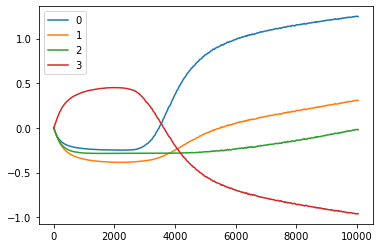

In [23]:
pd.DataFrame([x[-1] for x in weights]).plot()

In [24]:
train_error = []

for i in range(len(result.history['accuracy'])):
    train_error.append(1-result.history['accuracy'][i])

train_error

[0.8551247417926788,
 0.5275022685527802,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.14487528800964355,
 0.144875288

#### The training error using the whole dataset as training set is approximately 0.13 or 13%.